In [14]:
import os
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2gray
from PIL import Image

class kart_frame:
    def __init__ (self, name, road):
        self.name = name
        self.road = road
        self.base_path = "dense_data/{}/{}/{}_{}.png"
        self.masks = []
        self.images = []
        self.image = None
        self.row = None  # Initialize row to None
        self.row1 = {}
        self.load_masks()
    
    def get_image_path(self):
        """
        Returns the path to the image file for the kart frame.
        """
        base_path = "dense_data/{}/{}/{}.png"
        return base_path.format(self.road, "frame", self.name)
            
    def load_masks(self):
        frames = ["frame","kart","nitro","background","bomb","pickup","projectile","track","combined"]
        for frame in frames:
            mask = {}
            image_prefix = "mask"
            
            if(frame == "frame"):
                image_prefix = "frame"
            elif(frame == "combined"):
                image_prefix="mask_combined"

            image_path = self.base_path.format(self.road, frame, image_prefix, self.name)

            mask[frame] = image_path
            if not os.path.exists(image_path):
                #print(f"Mask not found: {image_path}")
                mask["hasMask"] = False
                mask["image"] = Image.new("RGB", (256, 256), color=(0, 100, 0)) 
            else:
                mask["hasMask"] = True
                mask["image"] = Image.open(image_path)

            mask["name"] = self.name
            mask["road"] = self.road
            mask["mask_name"] = f"{self.name}_{frame}"
            mask["image_prefix"] = image_prefix
            mask["image_path"] = image_path
            mask["frame"] = frame
            self.image = mask["image"]  # Store the last loaded image as the main image
            
            self.masks.append(mask)

        self.row = self.get_frame_as_row()
        self.row1["has_kart_frame"] = [item["hasMask"] for item in self.masks if item["frame"] == "kart"][0]


    def print_info(self):
        print(f"Name: {self.name}")
        print(f"Road: {self.road}")
        print("Masks:")
        for mask in self.masks:
            print(f"  - {mask['mask_name']} (Path: {mask['image_path']}, Has Mask: {mask['hasMask']})")

    def print_masks(self):
        fig, ax = plt.subplots(3,3,figsize=(10, 10))

        index = 0
        for i in range(3):
            for j in range(3):        
                img = self.masks[index]["image"]#images[index]
                name = self.masks[index]["mask_name"]#names[index]
                ax[i][j].imshow(img, cmap="gray")
                ax[i][j].axis('off')
                ax[i][j].set_title(name)
                index += 1
                
        plt.tight_layout()
        plt.show()

    def ensure_grayscale(self, img):
        """
        Devuelve una versión en escala de grises de una imagen.
        Si ya está en escala de grises, la devuelve tal cual.
        """
        img_array = np.array(img)

        if len(img_array.shape) == 2:
            return img_array  # Ya es gris
        elif len(img_array.shape) == 3 and img_array.shape[2] == 3:
            return rgb2gray(img_array)
        else:
            raise ValueError(f"Formato de imagen no soportado: {img_array.shape}")

    def get_similar_mask(self, mask_to_compare, num_classes=2):
        """
        Compara una máscara con una lista de máscaras usando Mean IoU
        y retorna la más similar.
        
        Args:
            mask_to_compare: máscara a comparar (imagen binaria o multiclase)
            num_classes: número de clases distintas en las máscaras

        Returns:
            similarity (float): Mean IoU.
            similar_mask: máscara más parecida.
        """
        frames_to_compare = ["kart","nitro","background","bomb","pickup","projectile","track"]

        best_similarity = 0.0
        similar_mask = None

        gray_mask_to_compare = self.ensure_grayscale(mask_to_compare)
        mask1 = (gray_mask_to_compare > 0.5).astype(np.uint8)

        for mask in self.masks:
            print(mask)
            if mask["frame"] not in frames_to_compare:
                continue
            if not mask.get("hasMask", False):
                continue
            print("#" * 20)
            print(mask["frame"])
            local_gray_mask = self.ensure_grayscale(mask["image"])
            mask2 = (local_gray_mask > 0.5).astype(np.uint8)

            if mask1.shape != mask2.shape:
                continue

            current_iou = self.compute_mean_iou(mask1, mask2, num_classes=num_classes)

            if current_iou > best_similarity:
                best_similarity = current_iou
                similar_mask = mask["image"]

        return best_similarity, similar_mask, mask["frame"]
    
    def compute_mean_iou(self, mask1, mask2, num_classes=2):
        """
        Compute mean Intersection over Union between two masks.
        Both masks must be NumPy arrays with the same shape.
        """
        mask1 = mask1.flatten()
        mask2 = mask2.flatten()
        ious = []

        for cls in range(num_classes):
            m1 = mask1 == cls
            m2 = mask2 == cls
            intersection = np.logical_and(m1, m2).sum()
            union = np.logical_or(m1, m2).sum()
            if union == 0:
                continue  # ignore classes not present
            ious.append(intersection / union)

        return np.mean(ious) if ious else 0.0      
    
    def get_frame_as_row(self):
        """
        Returns the row of the kart frame.
        """

        if self.image is None:
            try:
                self.image = Image.open(self.get_image_path()).convert("RGB")
            except FileNotFoundError:
                print(f"[WARN] Imagen no encontrada: {self.get_image_path()}")
                self.image = Image.new("RGB", (256, 256), color=(255, 0, 0)) 
        row = {}

        row["path"] = self.get_image_path()
        row["name"] = self.name
        row["road"] = self.road
        row["image"] = self.image
        row["has_kart_frame"] = any(item["frame"] == "kart" and item["hasMask"] for item in self.masks)
        row["has_nitro_frame"] = any(item["frame"] == "nitro" and item["hasMask"] for item in self.masks)
        row["has_background_frame"] = any(item["frame"] == "background" and item["hasMask"] for item in self.masks)
        row["has_bomb_frame"] = any(item["frame"] == "bomb" and item["hasMask"] for item in self.masks)
        row["has_pickup_frame"] = any(item["frame"] == "pickup" and item["hasMask"] for item in self.masks)
        row["has_projectile_frame"] = any(item["frame"] == "projectile" and item["hasMask"] for item in self.masks)
        row["has_track_frame"] = any(item["frame"] == "track" and item["hasMask"] for item in self.masks)

        row["has_predicted_frame"] = False
        row["has_predicted_nitro"] = False
        row["has_predicted_background"] = False
        row["has_predicted_bomb"] = False
        row["has_predicted_pickup"] = False
        row["has_predicted_projectile"] = False
        row["has_predicted_track"] = False

        return row


In [15]:
import os
import torch
import numpy as np
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2

class SuperTuxKartDataset(Dataset):
    def __init__(self, root_dir, tracks, transform_img=None, transform_mask=None):
        if isinstance(tracks, str):
            tracks = [tracks]

        self.image_paths = []
        self.mask_paths = []

        for track in tracks:
            image_dir = os.path.join(root_dir, track, "frame")
            mask_dir = os.path.join(root_dir, track, "combined")

            image_files = sorted([
                f for f in os.listdir(image_dir) if f.endswith(".png")
            ])
            mask_files = sorted([
                f for f in os.listdir(mask_dir) if f.endswith(".png")
            ])

            assert len(image_files) == len(mask_files), f"Track '{track}' tiene distinto número de imágenes y máscaras."
            
            for img_file, mask_file in zip(image_files, mask_files):
                self.image_paths.append(os.path.join(image_dir, img_file))
                self.mask_paths.append(os.path.join(mask_dir, mask_file))

        self.transform_img = transform_img
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path)

        if self.transform_img:
            image = self.transform_img(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)
        else:
            mask = torch.from_numpy(np.array(mask)).long()

        return image, mask
    
    def get_frame_object(self, idx):
        """
        Returns the kart_frame object for the given index.
        """
        if idx < 0 or idx >= len(self.image_paths):
            raise IndexError("Index out of range")

        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        name = os.path.splitext(os.path.basename(img_path))[0]
        road = os.path.basename(os.path.dirname(os.path.dirname(img_path)))

        frame = kart_frame(name, road)
        frame.image = Image.open(img_path).convert('RGB')
        
        frame.load_masks()
        
        return frame
    
    def get_frame_collection(self):
        """
        Returns a list of kart_frame objects for the dataset.
        """
        frames = []
        for idx in range(len(self)):
            frames.append(self.get_frame_object(idx))
        return frames
    
    def to_dataframe(self):
        """
        Transforma el dataset en un DataFrame donde cada fila es una instancia del objeto `kart_frame`.
        """
        rows = []

        for idx in range(len(self)):
            name = os.path.splitext(os.path.basename(self.image_paths[idx]))[0]
            road = os.path.basename(os.path.dirname(os.path.dirname(self.image_paths[idx])))
            frame = kart_frame(name, road)
            row = frame.get_frame_as_row()
            rows.append(row)

        return pd.DataFrame(rows)

In [16]:
from collections import Counter

def get_class_name(index):
    class_names = [
        "Background", "Track", "Kart", "Pickup", "Nitro", "Bomb", "Projectile"
    ]
    if 0 <= index < len(class_names):
        return class_names[index]
    else:
        return "Unknown Class"

def contar_clases_dataset(dataset):
    contador = Counter()

    for _, mask in dataset:
        if mask.ndim == 3 and mask.shape[0] == 1:
            mask = mask.squeeze(0)
        valores, conteos = torch.unique(mask, return_counts=True)
        for val, count in zip(valores.tolist(), conteos.tolist()):
            contador[val] += count

    print("Distribución de clases en el dataset:")
    for clase, cantidad in sorted(contador.items()):
        print(f"Clase { get_class_name(clase)}: {cantidad} píxeles")

    return contador

def tiene_clase_rara(mask):
  clases_raras = {3, 4, 5, 6}
  return any(c in clases_raras for c in torch.unique(mask).tolist())

def get_rare_sample(dataset):
  rare_samples = [dataset[i] for i in range(len(dataset)) if tiene_clase_rara(dataset[i][1])]
  return rare_samples

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import re

tracks = ["olivermath", "abyss", "gran_paradiso_island", "lighthouse","volcano_island","hacienda"]

frames_collection = []

for track in tracks:
    frame_dir = os.path.join("dense_data", track,"frame")
    if not os.path.exists(frame_dir):
        print(f"Directorio no encontrado: {frame_dir}")
        continue
    frame_files = sorted([f for f in os.listdir(frame_dir) if f.endswith(".png")])

    for filename in frame_files:
        match = re.search(r'frame_(\d+)\.png', filename)

        if match:
            number = match.group(1)
            kframe = kart_frame(number, track)

            frames_collection.append(kframe.row)

df = pd.DataFrame(frames_collection)

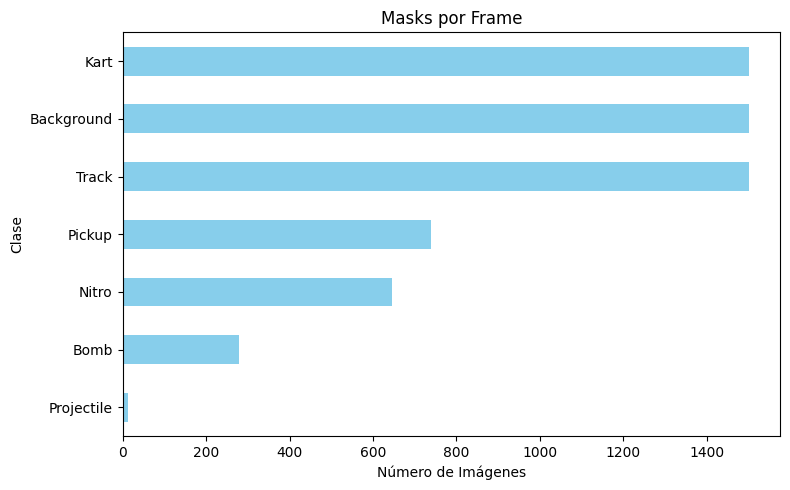

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import os

df_predicted = df[[col for col in df.columns if '_predicted_' not in col]]

df_predicted = df_predicted.rename(columns={
    'has_kart_frame': 'Kart',
    'has_background_frame': 'Background',
    'has_nitro_frame': 'Nitro',
    'has_bomb_frame': 'Bomb',
    'has_pickup_frame': 'Pickup',
    'has_projectile_frame': 'Projectile',
    'has_track_frame': 'Track',
})

bool_columns = df_predicted.select_dtypes(include='bool').columns
conteo_true = df_predicted[bool_columns].sum().sort_values(ascending=False)

import matplotlib.pyplot as plt

conteo_true.plot(kind="barh", figsize=(8, 5), color="skyblue")
plt.xlabel("Número de Imágenes")
plt.ylabel("Clase")
plt.title("Masks por Frame")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Imagen: torch.Size([3, 224, 224]), Máscara: torch.Size([1, 224, 224]), Clases: tensor([0, 1, 2, 4])


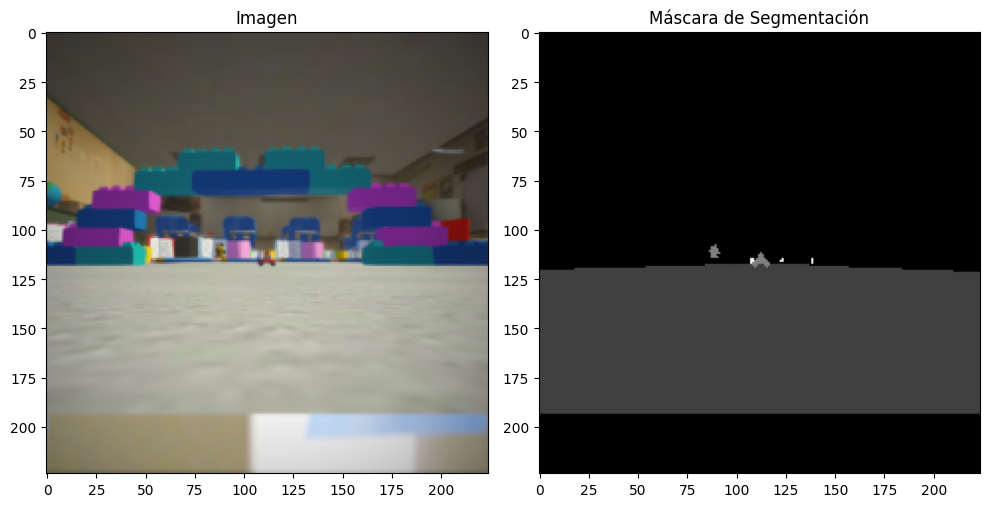

In [53]:
from torchvision.transforms import v2
from torch.utils.data import DataLoader, random_split
from torch.utils.data import ConcatDataset

CMAP="gray"

transform_img_old = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.CenterCrop(400),
    v2.Resize((224, 224))
])

transform_mask = v2.Compose([
    v2.ToImage(),
    v2.CenterCrop(400),
    v2.Resize((224, 224), interpolation=Image.NEAREST),
    v2.ToDtype(torch.int64)
])

tracks = ["olivermath", "abyss", "gran_paradiso_island", "lighthouse","volcano_island","hacienda"]

dataset = SuperTuxKartDataset(
    root_dir="dense_data",
    tracks=tracks,
    transform_img=transform_img_old,
    transform_mask=transform_mask
)

rare_samples = get_rare_sample(dataset)
augmented_dataset = ConcatDataset([dataset] + [rare_samples] * 10)

train_size = int(0.8 * len(augmented_dataset))
test_size = len(augmented_dataset) - train_size
train_dataset, test_dataset = random_split(augmented_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_dataset, batch_size=180, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=180, shuffle=False)

img, mask = dataset[0]

print(f"Imagen: {img.shape}, Máscara: {mask.shape}, Clases: {torch.unique(mask)}")

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img.permute(1, 2, 0).cpu().numpy())
plt.title("Imagen")

plt.subplot(1, 2, 2)
plt.imshow(mask.squeeze().cpu().numpy(), cmap=CMAP)
plt.title("Máscara de Segmentación")

plt.tight_layout()
plt.show()

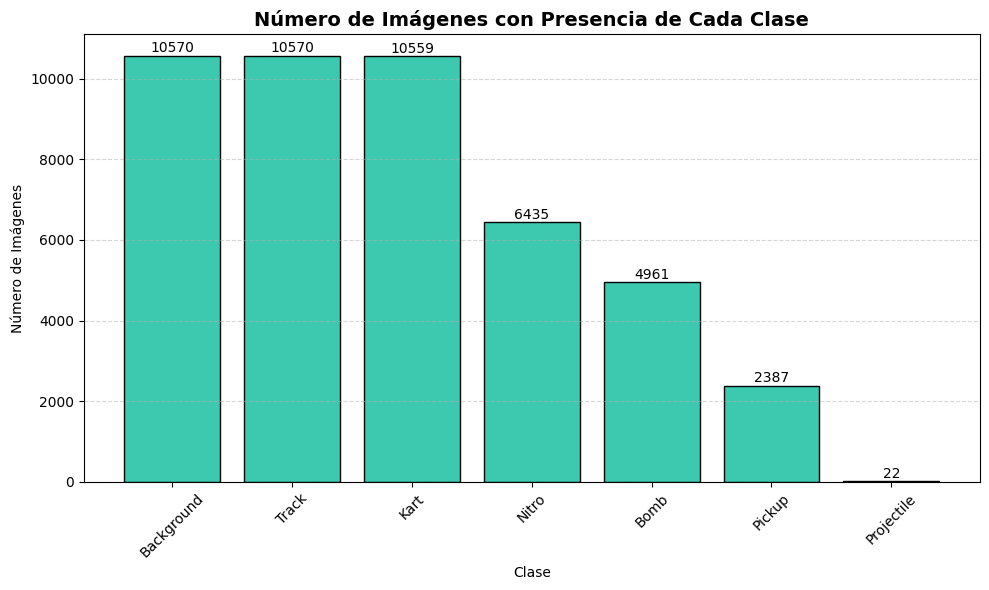

In [ ]:
from collections import Counter
import torch
from torch.utils.data import Dataset

def contar_presencia_por_imagen(dataset, num_clases=7):
    contador = Counter()

    for i in range(len(dataset)):
        _, mask = dataset[i]
        clases_presentes = torch.unique(mask).tolist()
        for clase in clases_presentes:
            contador[clase] += 1

    return contador 

class_names = {
    0: 'Background',
    1: 'Track',
    2: 'Kart',
    3: 'Nitro',
    4: 'Bomb',
    5: 'Pickup',
    6: 'Projectile',
    
}

def plot_presencia_imagenes(contador):
    clases = sorted(contador.keys())
    nombres = [class_names[c] for c in clases]
    conteos = [contador[c] for c in clases]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(nombres, conteos, color="#3DC9B0", edgecolor="black")

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 5,
                 str(height), ha='center', va='bottom', fontsize=10)

    plt.title("Número de Imágenes con Presencia de Cada Clase", fontsize=14, weight='bold')
    plt.xlabel("Clase")
    plt.ylabel("Número de Imágenes")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


contador = contar_presencia_por_imagen(augmented_dataset)
plot_presencia_imagenes(contador)


In [9]:
!pip3 install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /private/var/folders/mt/ynd178zj0lsf9_dhk8rpqy200000gn/T/pip-req-build-c2rljlix
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /private/var/folders/mt/ynd178zj0lsf9_dhk8rpqy200000gn/T/pip-req-build-c2rljlix
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [26]:
import torch
import matplotlib.pyplot as plt
import cv2
import numpy as np
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator


frame = kart_frame("0100", "abyss")
image_path = frame.get_image_path()
print(f"Loading image from: {image_path}")
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

sam_checkpoint = "sam_vit_b_01ec64.pth"
model_type = "vit_b"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
mask_generator = SamAutomaticMaskGenerator(sam)

masks = mask_generator.generate(image)

def visualize_masks(image, masks):
    for i, mask_data in enumerate(masks):
        plt.figure()
        plt.imshow(image)
        plt.imshow(mask_data["segmentation"], alpha=0.5)
        plt.title(f"Mask {i+1} - Score: {mask_data['predicted_iou']:.3f}")
        plt.axis("off")
    plt.show()

#visualize_masks(image, masks)

Loading image from: dense_data/abyss/frame/0100.png


[ WARN:0@1174.305] global loadsave.cpp:268 findDecoder imread_('dense_data/abyss/frame/0100.png'): can't open/read file: check file path/integrity


error: OpenCV(4.11.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


Clases presentes en la máscara: [0, 1, 2]


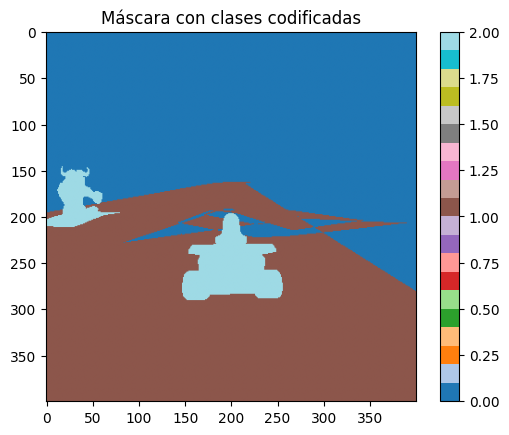

In [46]:
from PIL import Image
import torch
import numpy as np

# Cargar la máscara
path = "dense_data/hacienda/combined/mask_combined_0005.png"
mask = Image.open(path)
mask_tensor = torch.tensor(np.array(mask), dtype=torch.int64)

# Revisar las clases presentes
clases_presentes = torch.unique(mask_tensor)
print(f"Clases presentes en la máscara: {clases_presentes.tolist()}")

import matplotlib.pyplot as plt

plt.imshow(mask_tensor, cmap='tab20')
plt.title("Máscara con clases codificadas")
plt.colorbar()
plt.show()

In [ ]:

binary_masks = [(mask_data["segmentation"]).astype(np.uint8) for mask_data in masks]

for mask in binary_masks:
    similarity, similar_mask, mask_name = frame.get_similar_mask(mask)

    print(f"Similarity: {similarity:.3f}")
    if similarity < 0.9:
        print(f"Masks are Different: {mask_name}")
        continue
    else:
        print(f"Masks are Similar: {mask_name}")

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(mask, cmap="gray")
    plt.title("Input Mask")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(similar_mask, cmap="gray")
    plt.title("Similar Mask")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


{'frame': 'frame', 'hasMask': True, 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=400x400 at 0x35D4F4650>, 'name': '0100', 'road': 'abyss', 'mask_name': '0100_frame', 'image_prefix': 'frame', 'image_path': 'dense_data/abyss/frame/frame_0100.png'}
{'kart': 'dense_data/abyss/kart/mask_0100.png', 'hasMask': True, 'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=400x400 at 0x35D491CD0>, 'name': '0100', 'road': 'abyss', 'mask_name': '0100_kart', 'image_prefix': 'mask', 'image_path': 'dense_data/abyss/kart/mask_0100.png', 'frame': 'kart'}
####################
kart
{'nitro': 'dense_data/abyss/nitro/mask_0100.png', 'hasMask': True, 'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=400x400 at 0x35D4928D0>, 'name': '0100', 'road': 'abyss', 'mask_name': '0100_nitro', 'image_prefix': 'mask', 'image_path': 'dense_data/abyss/nitro/mask_0100.png', 'frame': 'nitro'}
####################
nitro
{'background': 'dense_data/abyss/background/mask_0100.png', 'hasMask': Tr

In [ ]:
!pip install peft


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision.transforms import v2
from PIL import Image
import math
from segment_anything import sam_model_registry

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sam_checkpoint = "sam_vit_b_01ec64.pth"
model_type = "vit_b"
num_classes = 7  
batch_size = 1   
epochs = 10

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device)
sam.eval()
image_encoder = sam.image_encoder

# --- Paso 2: LoRA Manual ---
class LoRALinear(nn.Module):
    def __init__(self, original_linear, r=8, alpha=16):
        super().__init__()
        self.original = original_linear
        self.r = r
        self.alpha = alpha

        in_features = original_linear.in_features
        out_features = original_linear.out_features

        self.lora_down = nn.Linear(in_features, r, bias=False)
        self.lora_up = nn.Linear(r, out_features, bias=False)

        self.scaling = alpha / r

        nn.init.kaiming_uniform_(self.lora_down.weight, a=math.sqrt(5))
        nn.init.zeros_(self.lora_up.weight)

    def forward(self, x):
        return self.original(x) + self.scaling * self.lora_up(self.lora_down(x))

def inject_lora_into_sam_old(sam, r=8, alpha=16):
    for name, module in sam.image_encoder.named_modules():
        if hasattr(module, 'qkv') and isinstance(module.qkv, nn.Linear):
            print(f"Inyectando LoRA en: {name}.qkv")
            module.qkv = LoRALinear(module.qkv, r=r, alpha=alpha)

def inject_lora_into_sam(sam, r=8, alpha=16, target_blocks=[8,9,10,11]):
    for name, module in sam.image_encoder.named_modules():
        for block_idx in target_blocks:
            if name == f"blocks.{block_idx}.attn" and hasattr(module, 'qkv') and isinstance(module.qkv, nn.Linear):
                print(f"Inyectando LoRA en: {name}.qkv")
                module.qkv = LoRALinear(module.qkv, r=r, alpha=alpha)

inject_lora_into_sam(sam)

class SAMLoRASegmentation(nn.Module):
    def __init__(self, encoder, num_classes):
        super().__init__()
        self.encoder = encoder
        self.decoder = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=4),
            nn.Conv2d(128, num_classes, kernel_size=1)
        )

    def forward(self, x):
        embeddings = self.encoder(x)
        return self.decoder(embeddings)

model = SAMLoRASegmentation(sam.image_encoder, num_classes).to(device)

# --- Paso 4: Dataset y transformaciones ---
# SAM usa normalización estilo ImageNet
mean = torch.tensor([123.675, 116.28, 103.53]) / 255.0
std = torch.tensor([58.395, 57.12, 57.375]) / 255.0

transform_img = v2.Compose([
    v2.ToImage(),
    v2.Resize((1024, 1024)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=mean.tolist(), std=std.tolist())
])

transform_mask = v2.Compose([
    v2.ToImage(),
    v2.Resize((256, 256), interpolation=Image.NEAREST),
    v2.ToDtype(torch.int64)
])

tracks = ["olivermath", "abyss", "gran_paradiso_island", "lighthouse", "volcano_island", "hacienda"]

dataset = SuperTuxKartDataset(
    root_dir="dense_data",
    tracks=tracks,
    transform_img=transform_img,
    transform_mask=transform_mask
)

rare_samples = get_rare_sample(dataset)
augmented_dataset = ConcatDataset([dataset] + [rare_samples] * 50)

train_size = int(0.8 * len(augmented_dataset))
test_size = len(augmented_dataset) - train_size
train_dataset, test_dataset = random_split(augmented_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# --- Paso 5: Entrenamiento ---

# Solo entrenamos LoRA y decoder
for name, param in model.named_parameters():
    if "lora" not in name.lower() and "decoder" not in name:
        param.requires_grad = False

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

for epoch in range(epochs):
    print("----"* 20)
    print(f"Epoch {epoch+1}/{epochs}")
    model.train()
    total_loss = 0
    counting = 0
    for images, masks in train_loader:
        
        images, masks = images.to(device), masks.to(device)
        preds = model(images)
        loss = F.cross_entropy(preds, masks.squeeze(1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        counting += 1
        if counting % 10 == 0:
            print(f"Batch size: {counting + 1} / {len(train_loader)}")
            print(f"Loss: {loss.item():.4f}")
            import time
            print(f"Time: {time.strftime('%H:%M:%S', time.gmtime())}")


    print(f"[{epoch+1}/{epochs}] Loss: {total_loss:.4f}")

Inyectando LoRA en: blocks.8.attn.qkv
Inyectando LoRA en: blocks.9.attn.qkv
Inyectando LoRA en: blocks.10.attn.qkv
Inyectando LoRA en: blocks.11.attn.qkv
--------------------------------------------------------------------------------
Epoch 1/10
Batch size: 11 / 38000
Loss: 1.7154
Time: 03:20:32
Batch size: 21 / 38000
Loss: 1.4630
Time: 03:20:57
Batch size: 31 / 38000
Loss: 1.2379
Time: 03:21:23
Batch size: 41 / 38000
Loss: 0.9843
Time: 03:21:48


KeyboardInterrupt: 